LOG WRITER DIMENSIONS

To look at full dataframe -> print(df) <br>
To look at seperated dataframe -> print(dfs)/print(dict['df_(dataframe number)']) <br>
To look at rank scores -> print(rank_dataframe)

In [1]:
def file_reader(dimension: str, size: str):
    global df
    global dfs
    if dimension == "storage":
        idx = []
        li=[]
        # READ LOG - STORAGE FORMAT
        for i in schemas:
            for j in partition:
                for k in file_format:
                    # check folder
                    # print(f'./logs/{k}/{size}M_{i}_{j}.txt')

                    df = pd.read_csv(f'./logs/{k}/{size}M_{i}_{j}.txt',sep = ',', header = None)
                    df = df.fillna(0)
                    avg = df.mean(axis = 0)
                    li.append(avg)
                    idx.append(k + f"_{i}_{j}")

        # create dataframe
        df = pd.DataFrame(li, index = [idx])
        df = df.set_axis(["Q"+str(i+1) for i in range(11)], axis = 1)
        df = df.fillna(5000)
        # split dataframe
        dict = {}
        count = 0
        loop = len(file_format)
        dfs = []
        for i in range(int(len(partition) * len(file_format) * len(schemas) / len(file_format))):
            dict['df_{}'.format(i)] = df[count:loop]
            count = loop
            loop = loop+len(file_format)
            dfs.append(dict[f'df_{i}'])
##################################################################################################################################
    elif dimension == "partition":
        idx = []
        li=[]
        # READ LOG - STORAGE FORMAT
        for i in schemas:
            for k in file_format:
                for j in partition:
                    # check folder
                    # print(f'./logs/{k}/100M_{i}_{j}.txt')

                    df = pd.read_csv(f'./logs/{k}/{size}M_{i}_{j}.txt',sep = ',', header = None)
                    df = df.fillna(0)
                    avg = df.mean(axis = 0)
                    li.append(avg)
                    idx.append(k + f"_{i}_{j}")

        # create dataframe
        df = pd.DataFrame(li, index = [idx])
        df = df.set_axis(["Q"+str(i+1) for i in range(11)], axis = 1)
        df = df.fillna(5000)
        # split dataframe
        dict = {}
        count = 0
        loop = len(partition)
        dfs = []
        for i in range(int(len(partition) * len(file_format) * len(schemas) / len(partition))):
            dict['df_{}'.format(i)] = df[count:loop]
            count = loop
            loop = loop+len(partition)
            dfs.append(dict[f'df_{i}'])
############################################################################################################################################################
    elif dimension == "schema":
        idx = []
        li=[]
    # READ LOG - STORAGE FORMAT
        for j in partition:
            for k in file_format:
                for i in schemas:
                    # check folder
                    # print(f'./logs/{k}/100M_{i}_{j}.txt')

                    df = pd.read_csv(f'./logs/{k}/{size}M_{i}_{j}.txt',sep = ',', header = None)
                    df = df.fillna(0)
                    avg = df.mean(axis = 0)
                    li.append(avg)
                    idx.append(k + f"_{i}_{j}")

        # create dataframe
        df = pd.DataFrame(li, index = [idx])
        df = df.set_axis(["Q"+str(i+1) for i in range(11)], axis = 1)
        df = df.fillna(5000)
        # split dataframe
        dict = {}
        count = 0
        loop = len(schemas)
        dfs = []
        for i in range(int(len(partition) * len(file_format) * len(schemas) / len(schemas))):
            dict['df_{}'.format(i)] = df[count:loop]
            count = loop
            loop = loop+len(schemas)
            dfs.append(dict[f'df_{i}'])
    
    return df

In [41]:
import matplotlib.pyplot as plt

# NON-DOMINATED SORTING ALGORITHM 
def nsga2(inputPoints, dominates):
    paretoPoints = set()
    candidateRowNr = 0
    dominatedPoints = set()
    while True:
        candidateRow = inputPoints[candidateRowNr] # masuk row pertama
        inputPoints.remove(candidateRow) # buang row pertamanya
        rowNr = 0
        nonDominated = True # row kandidat yg baru masuk di set true buat non dominated nya
        while len(inputPoints) != 0 and rowNr < len(inputPoints):
            row = inputPoints[rowNr] # ambil row lanjutannya
            if dominates(candidateRow, row): # ngecek row kandidat ama row lanjutan di input_point dominasinya
                # If it is worse on all features remove the row from the array
                inputPoints.remove(row)
                dominatedPoints.add(tuple(row))
            elif dominates(row, candidateRow):
                nonDominated = False
                dominatedPoints.add(tuple(candidateRow))
                rowNr += 1
            else:
                rowNr += 1

        if nonDominated:
            # add the non-dominated point to the Pareto frontier
            paretoPoints.add(tuple(candidateRow))

        if len(inputPoints) == 0:
            break
    return paretoPoints, dominatedPoints

def dominates(row, candidateRow):
    return np.sum([row[x] <= candidateRow[x] for x in range(len(row))]) == len(row)# kalo lebih kecil semua berarti dominasi
def dominates_agg(row, candidateRow):
    return np.sum([row[x] >= candidateRow[x] for x in range(len(row))]) == len(row)

# DRAW PARETO DIAGRAM
def getDiagramPareto():
    fig = plt.figure()
    fig.set_size_inches(15, 15)
    ax = fig.add_subplot(111, projection='3d')
    dp = np.array(list(dominatedPoints))
    pp = np.array(list(paretoPoints))

    print(pp.shape,dp.shape)
    ax.scatter(dp[:,0],dp[:,1],dp[:,2])
    ax.scatter(pp[:,0],pp[:,1],pp[:,2],color='green')

    ax.set_xlabel('Rf')
    ax.set_ylabel('Rp')
    ax.set_zlabel('Rs')
    
    import matplotlib.tri as mtri
    triang = mtri.Triangulation(pp[:,0],pp[:,1])
    ax.plot_trisurf(triang,pp[:,2],color='green',alpha=0.3)
    plt.show()
    
# CREATE DICTIONARY WITH RANKS AS KEY AND INDEX AS VALUE
def getConfs(points,orignaldf):
  point_confs = {}
  for i in range(0, len(orignaldf)):
    for val in points:
      if (list(val)==np.array(orignaldf[i][1:], dtype=np.float64).tolist()):
        point_confs[val]=orignaldf[i][0]

  return point_confs

def getConfsSorted(confsDict):  
  # # summing all the values using sum()
  temp1 = {val: sum(float(idx) for idx in val) 
            for val, key in confsDict.items()} #sum the ranks of non dominated solution
        
  # using sorted to perform sorting as required
  temp2 = sorted(temp1.items(), key = lambda ele : temp1[ele[0]],reverse=False) #sort according to the sum before
  res={}
  for key, val in temp2:
    res[key]=confsDict[key]

  #print("The sorted dictionary : " + str(res))
  return res

def getPareto_Q(size):
    global paretoPoints
    global dominatedPoints
    global pareto_q
    
    file_reader(dimension,size)
    
    dimensionsAll = getRanking().reset_index().values
    dimensions = np.array(getRanking()[:], dtype = np.float64)
    inputPoints = dimensions.tolist()
    paretoPoints, dominatedPoints = nsga2(inputPoints, dominates)

    pareto_q = getConfs(paretoPoints, dimensionsAll)
    pareto_q = getConfsSorted(pareto_q)

    vals = np.array(list(pareto_q.values()))
    table_pareto = pd.DataFrame({'Solution': vals}, columns=['Solution'])

    dominated=  getConfs(dominatedPoints, dimensionsAll)
    dominated = getConfsSorted(dominated)
    vals = np.array(list(dominated.values()))
    table_dominated = pd.DataFrame({'Dominated': vals}, columns=['Dominated'])

    table = pd.concat([table_pareto, table_dominated], axis = 1)
    table = table.replace(np.nan, '', regex=True)
    return table

def getPareto_Agg(size):
    global paretoPoints
    global dominatedPoints
    global pareto_agg
    
    file_reader('schema',size)
    var1 = R_score()['Result']
    file_reader('storage',size)
    var2 = R_score()['Result'] 
    file_reader('partition',size)
    var3 = R_score()['Result']

    new_df = pd.concat([var1, var2, var3], axis = 1)
    new_df.index = new_df.index.str.replace(' ', '_')
    dimensionsAll = new_df.reset_index().values
    dimensions = np.array(dimensionsAll[:,1:], dtype = np.float64)

    inputPoints = dimensions.tolist()
    paretoPoints, dominatedPoints = nsga2(inputPoints, dominates_agg)

    pareto_agg = getConfs(paretoPoints, dimensionsAll)
    pareto_agg = getConfsSorted(pareto_agg)
    vals = np.array(list(pareto_agg.values()))
    table_pareto = pd.DataFrame(vals, columns=['Solution'])

    dominated = getConfs(dominatedPoints, dimensionsAll)
    dominated = getConfsSorted(dominated)
    vals = np.array(list(dominated.values()))
    table_dominated = pd.DataFrame({'Dominated': vals}, columns=['Dominated'])
    
    table = pd.concat([table_pareto, table_dominated], axis = 1)
    table = table.replace(np.nan, '', regex=True)
    return table

In [96]:
def R_score(dimension, size):
    # CREATE RANK OCCURENCES        
    global rank_dataframe
    global rank_dataframe_rscore
    
    file_reader(dimension,size)
    
    rank_dataframe = []

    for x in dfs:
        df_ranks = x.T
        column_names = df_ranks.columns.to_numpy().tolist()
        column_names = [column_names for column_names, in column_names]
        
        df_ranks_occurences = []
        for index, row in df_ranks.iterrows():
            df_ranks_occurences.append(ss.rankdata(row, method = 'max'))

        df_ranks_occurences = pd.DataFrame(df_ranks_occurences)

        df_transpose = df_ranks_occurences.transpose()

        rank_table = []
        for index, row in df_transpose.iterrows():
            result_row = np.zeros(len(df_transpose.index))
            for i in range(len(row)):
                result_row[int(row[i])-1] +=1
            rank_table.append(result_row)

        rank_table = pd.DataFrame(rank_table)
        rank_table = rank_table.set_axis(column_names, axis = 'index')
        rank_table = rank_table.set_axis([i+1 for i in range(len(column_names))], axis='columns')

        # CREATE R SCORE
        q = 11
        d = len(rank_table.index)

        rank_score = []
        for index, row in rank_table.iterrows():
            s = 0
            for r in range(d):  
                s = s + (row[r+1]*(d-(r+1)) / (q*(d-1)) )
            rank_score.append(s)
        rank_score = pd.DataFrame(rank_score)
        rank_score = rank_score.set_axis(column_names, axis = 'index')
        rank_score = rank_score.set_axis(['Result'], axis='columns')
        rank_score = pd.concat([rank_table, rank_score], axis = 1)
        rank_dataframe.append(rank_score)
    rank_dataframe_rscore = pd.concat(rank_dataframe)
    rank_dataframe_rscore.index = rank_dataframe_rscore.index.str.replace('_', ' ', regex=True)
    
    return rank_dataframe_rscore

In [4]:
def rank_part(param1, param2):
    result = []
    for x in param1:
        for y in param2:
            test = rank_dataframe_rscore.loc[rank_dataframe_rscore.index.str.contains(fr'(?=.*\b{x}\b)(?=.*\b{y}\b)', regex=True)]
            result.append(test)
    
    table = pd.concat(result)
    return table            

In [22]:
def getDiagramSD(a):
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    from matplotlib.pyplot import figure
    
    if dimension == "partition":
        if a not in partition:
            filter = rank_dataframe_rscore.loc[rank_dataframe_rscore.index.str.contains(fr'\b{a}\b', regex = True)]
            
            if a in file_format:
                dict = {}
                loop = len(partition)
                count = 0
                for i in schemas:
                    dict['{}'.format(i)] = filter[count:loop]
                    count = loop
                    loop = loop+len(partition)

                key = list(dict)
                dict2 = {}
                # allVal = np.empty([0,4])
                for j in range(len(schemas)):
                    val = list(dict[key[j]]['Result'])
                    dict2['val{}'.format(j)] = val
                    
                data = np.vstack(list(dict2.values()))
                df2 = pd.DataFrame(data=data, index=list(dict.keys()), columns=partition)
                return df2.plot.bar(title = str(a) + " diagram", rot=0, fontsize = 14, figsize = (10,10))
                
            elif a in schemas:
                dict = {}
                loop = len(partition)
                count = 0
                for i in file_format:
                    dict['{}'.format(i)] = filter[count:loop]
                    count = loop
                    loop = loop+len(partition)

                key = list(dict)
                dict2 = {}
                # allVal = np.empty([0,4])
                for j in range(len(file_format)):
                    val = list(dict[key[j]]['Result'])
                    dict2['val{}'.format(j)] = val
                    
                data = np.vstack(list(dict2.values()))
                df2 = pd.DataFrame(data=data, index=list(dict.keys()), columns=partition)
                return df2.plot.bar(title = str(a) + " diagram", rot=0, fontsize = 14, figsize = (10,10))
                
                # for container in ax.containers:
                #     ax.bar_label(container)
        else:
            return 'the dimension is partition!'
    
    if dimension == "schema":
        if a not in schemas:
            filter = rank_dataframe_rscore.loc[rank_dataframe_rscore.index.str.contains(fr'\b{a}\b', regex = True)]
            
            if a in file_format:
                dict = {}
                loop = len(schemas)
                count = 0
                for i in partition:
                    dict['{}'.format(i)] = filter[count:loop]
                    count = loop
                    loop = loop+len(schemas)

                key = list(dict)
                dict2 = {}
                # allVal = np.empty([0,4])
                for j in range(len(partition)):
                    val = list(dict[key[j]]['Result'])
                    dict2['val{}'.format(j)] = val
                    
                data = np.vstack(list(dict2.values()))
                df2 = pd.DataFrame(data=data, index=list(dict.keys()), columns=schemas)
                return df2.plot.bar(title = str(a) + " diagram", rot=0, fontsize = 14, figsize = (10,10))
                
            elif a in partition:
                dict = {}
                loop = len(schemas)
                count = 0
                for i in file_format:
                    dict['{}'.format(i)] = filter[count:loop]
                    count = loop
                    loop = loop+len(schemas)

                key = list(dict)
                dict2 = {}
                # allVal = np.empty([0,4])
                for j in range(len(file_format)):
                    val = list(dict[key[j]]['Result'])
                    dict2['val{}'.format(j)] = val
                    
                data = np.vstack(list(dict2.values()))
                df2 = pd.DataFrame(data=data, index=list(dict.keys()), columns=schemas)
                return df2.plot.bar(title = str(a) + " diagram", rot=0, fontsize = 14, figsize = (10,10))
        else:
            return 'the dimension is schema!'
    
    if dimension == "storage":
        if a not in file_format:
            filter = rank_dataframe_rscore.loc[rank_dataframe_rscore.index.str.contains(fr'\b{a}\b', regex = True)]

            if a in schemas:
                dict = {}
                loop = len(file_format)
                count = 0
                for i in partition:
                    dict['{}'.format(i)] = filter[count:loop]
                    count = loop
                    loop = loop+len(file_format)

                key = list(dict)
                dict2 = {}
                # allVal = np.empty([0,4])
                for j in range(len(partition)):
                    val = list(dict[key[j]]['Result'])
                    dict2['val{}'.format(j)] = val
                    
                data = np.vstack(list(dict2.values()))
                df2 = pd.DataFrame(data=data, index=list(dict.keys()), columns=file_format)
                return df2.plot.bar(title = str(a) + " diagram", rot=0, fontsize = 14, figsize = (10,10))
                
            elif a in partition:
                dict = {}
                loop = len(file_format)
                count = 0
                for i in schemas:
                    dict['{}'.format(i)] = filter[count:loop]
                    count = loop
                    loop = loop+len(file_format)

                key = list(dict)
                dict2 = {}
                # allVal = np.empty([0,4])
                for j in range(len(schemas)):
                    val = list(dict[key[j]]['Result'])
                    dict2['val{}'.format(j)] = val
                    
                data = np.vstack(list(dict2.values()))
                df2 = pd.DataFrame(data=data, index=list(dict.keys()), columns=file_format)
                return df2.plot.bar(title = str(a) + " diagram", rot=0, fontsize = 14, figsize = (10,10))
        else:
            return 'the dimension is storage!'

In [6]:
def getConformance(dimension, dataset, nValue: int, higherThan: int):
    global df_transpose
    
    #CREATE CRITERIA TABLE
    data = []
    for x in dimension:
        for y in dataset:
            print(x,y)
            file_reader(x,y)
            R_score()
            criteria_table = getRanking().loc[bestOfSD(nValue)]
            if x == 'pareto_Q':
                file_reader('storage',y)
                getPareto_Q(y)
                criteria_table = getRanking().loc[list(pareto_q.values())[:nValue]]
            if x == 'pareto_Agg':
                getPareto_Agg(y)
                criteria_table = getRanking().loc[list(pareto_agg.values())[:nValue]]  
            
            # GET CONFIGURATION THAT IS HIGHER THAN 30% OF TOTAL CONFIGURATION
            criteria_table = criteria_table[criteria_table > higherThan]
            count = criteria_table.count(axis=1)
            avg = count.mean(axis = 0)
            # count, avg
            # GET CONFORMANCE
            sum = count.sum(axis = 0)
            conformance = 1 - (sum/(nValue*11)) #what is 55??
            data.append(conformance)
    data = np.array(data).reshape(len(dimension), len(dataset))
    table = pd.DataFrame(data, index=dimension, columns=dataset)
    return table

#GET BEST SCORES OF 5
def bestOfSD(nValue):
    full_ranks_scores = pd.concat(rank_dataframe, axis = 0)
    full_ranks_scores = full_ranks_scores['Result']
    best_scores = full_ranks_scores.nlargest(nValue)
    return best_scores.index.to_numpy().tolist()

# GET RANKS OF THE DATAFRAME
def getRanking():
    global df_full_ranks
    global df_transpose
    
    df_transpose = df.T
    df_full_ranks = []
    for index, row in df_transpose.iterrows():
        df_full_ranks.append(ss.rankdata(row, method = 'max'))
    df_full_ranks = pd.DataFrame(df_full_ranks)
    df_full_ranks = df_full_ranks.T
    df_full_ranks = df_full_ranks.set_axis(df_transpose.columns, axis = 'index') #configurations  
    df_full_ranks = df_full_ranks.set_axis([i+1 for i in range(len(df_transpose.index))], axis='columns') #query
    
    return df_full_ranks

In [94]:
def getCoherence(dimension, dataset1: int, dataset2: int):
    score = []
    distance = []
    for x in dimension:
        if x == 'pareto_Q':
            file_reader('storage', dataset1)
            R_score()
            getPareto_Q(dataset1)
            var1 = pd.concat(rank_dataframe, axis = 0)
            var1 = var1.loc[list(pareto_q.values())]
            var1 = var1['Result']
            
            file_reader('storage',dataset2)
            R_score()
            getPareto_Q(dataset2)
            var2 = pd.concat(rank_dataframe, axis = 0)
            var2 = var2.loc[list(pareto_q.values())]
            var2 = var2['Result']
            
            new_df = pd.concat([var1, var2], axis = 1)
            column_name = new_df.columns.values
            column_name[0] = str(dataset1) #var1
            column_name[1] = str(dataset2) #var2

            new_df.columns = column_name
            new_df = new_df.fillna(1)
            var1 = new_df[str(dataset1)]
            var2 = new_df[str(dataset2)]
        
        elif x == 'pareto_Agg':    
            getPareto_Agg(dataset1)
            var1 = pd.concat(rank_dataframe, axis = 0)
            var1 = var1.loc[list(pareto_agg.values())]
            var1 = var1['Result']
            
            getPareto_Agg(dataset2)
            var2 = pd.concat(rank_dataframe, axis = 0)
            var2 = var2.loc[list(pareto_agg.values())]
            var2 = var2['Result']
            
            new_df = pd.concat([var1, var2], axis = 1)
            column_name = new_df.columns.values
            column_name[0] = str(dataset1) #var1
            column_name[1] = str(dataset2) #var2

            new_df.columns = column_name
            new_df = new_df.fillna(1)
            var1 = new_df[str(dataset1)]
            var2 = new_df[str(dataset2)]
        else:
            file_reader(x, dataset1)
            R_score()
            var1 = pd.concat(rank_dataframe, axis = 0)
            var1 = var1['Result']
            
            file_reader(x,dataset2)
            R_score()
            var2 = pd.concat(rank_dataframe, axis = 0)
            var2 = var2['Result']

        # KENDALL'S SCORE
        result, pvalue = ss.kendalltau(var1,var2, nan_policy = 'omit', method = 'asymptotic', variant = 'b')
        score.append(result)
        # KENDALL'S DISTANCE
        var1_array = var1.to_numpy()
        var2_array = var2.to_numpy()
        res = normalised_kendall_tau_distance(var1_array, var2_array)
        distance.append(res)
        
    data = np.vstack((score, distance))
    return pd.DataFrame(data, columns = dimension, index=['score', 'distance'])

# kendall's distance
def normalised_kendall_tau_distance(values1, values2):
    """Compute the Kendall tau distance."""
    n = len(values1)
    assert len(values2) == n, "Both lists have to be of equal length"
    i, j = np.meshgrid(np.arange(n), np.arange(n))
    a = np.argsort(values1)
    b = np.argsort(values2)
    ndisordered = np.logical_or(np.logical_and(a[i] < a[j], b[i] > b[j]), np.logical_and(a[i] > a[j], b[i] < b[j])).sum()
    return ndisordered / (n * (n - 1))
    

<h3>This is a script to find the best performing configuration from a set of dimensions (partition, schema, storage)</h3>

Query runtimes of a single dimension set of configuration

In [106]:
# SINGLE DIMENSION #
import pandas as pd
import scipy.stats as ss
import numpy as np
file_format = ['csv', 'avro', 'parquet', 'orc']
schemas = ['st','vt', 'pt', 'extvt', 'wpt']
partition = ['horizontal','predicate', 'subject']
dimension = 'storage'
size = '250'

file_reader(dimension,size)

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11
csv_st_horizontal,119.811581,434.534540,79.208559,833.553244,252.741987,299.149741,426.360434,537.442719,191.678927,53.058458,35.071883
avro_st_horizontal,61.605208,179.621290,31.063134,658.834816,95.885596,186.678078,288.816110,429.985433,119.866340,29.200286,12.852418
parquet_st_horizontal,39.440573,113.749201,14.500456,591.184875,75.671910,163.391413,245.607044,407.764548,91.364784,7.588160,3.869994
orc_st_horizontal,42.378732,110.825400,13.158544,656.996972,66.485270,203.631652,270.351702,407.240550,94.448321,6.983642,2.788286
csv_st_predicate,116.212925,408.827237,78.534839,823.262067,238.636782,309.673484,409.171700,548.116276,168.274577,82.144783,36.702343
avro_st_predicate,81.318466,164.169820,33.614049,710.471017,104.377956,274.194727,317.947424,485.456736,117.760664,46.507032,21.584215
parquet_st_predicate,54.538511,108.107410,28.664667,643.646836,89.637053,158.227649,268.950900,466.422044,112.448237,14.846991,4.670535
orc_st_predicate,41.796522,98.734800,21.105655,590.733618,72.615040,164.572155,203.416994,448.890928,96.341208,10.637278,2.523962
csv_st_subject,116.935944,422.748822,76.498997,796.847481,246.557554,271.979034,388.947217,527.328294,188.356603,54.592933,34.044350
avro_st_subject,57.643287,169.955491,27.962208,619.322019,89.408717,215.052230,347.350987,426.598422,119.673505,27.230969,12.104282


This is the Rank Scores of the ranked dimension ((i.e relational schema, partitioning technique, or storage backend)

In [105]:
dimension = 'storage'
size = 250
R_score(dimension, size) #give parameters dimension and dataset, guidelines

,1,2,3,4,Result
csv st horizontal,0.0,0.0,0.0,11.0,0.000000
avro st horizontal,0.0,1.0,10.0,0.0,0.363636
parquet st horizontal,5.0,6.0,0.0,0.0,0.818182
orc st horizontal,6.0,4.0,1.0,0.0,0.818182
csv st predicate,0.0,0.0,0.0,11.0,0.000000
avro st predicate,0.0,0.0,11.0,0.0,0.333333
parquet st predicate,1.0,10.0,0.0,0.0,0.696970
orc st predicate,10.0,1.0,0.0,0.0,0.969697
csv st subject,0.0,0.0,0.0,11.0,0.000000
avro st subject,0.0,0.0,11.0,0.0,0.333333


In [15]:
param1 = ['csv','avro']
param2 = ['st', 'vt']
rank_part(param1, param2) #make parameter as list

,1,2,3,Result
csv st horizontal,1.0,3.0,7.0,0.227273
csv st predicate,4.0,3.0,4.0,0.500000
csv st subject,6.0,5.0,0.0,0.772727
csv vt horizontal,3.0,3.0,5.0,0.409091
csv vt predicate,4.0,1.0,6.0,0.409091
csv vt subject,4.0,7.0,0.0,0.681818
avro st horizontal,2.0,7.0,2.0,0.500000
avro st predicate,2.0,1.0,8.0,0.227273
avro st subject,7.0,3.0,1.0,0.772727
avro vt horizontal,0.0,4.0,7.0,0.181818


This diagram shows the performance of a single dimension parameters that the user choose in terms of their rank scores

<AxesSubplot:title={'center':'parquet diagram'}>

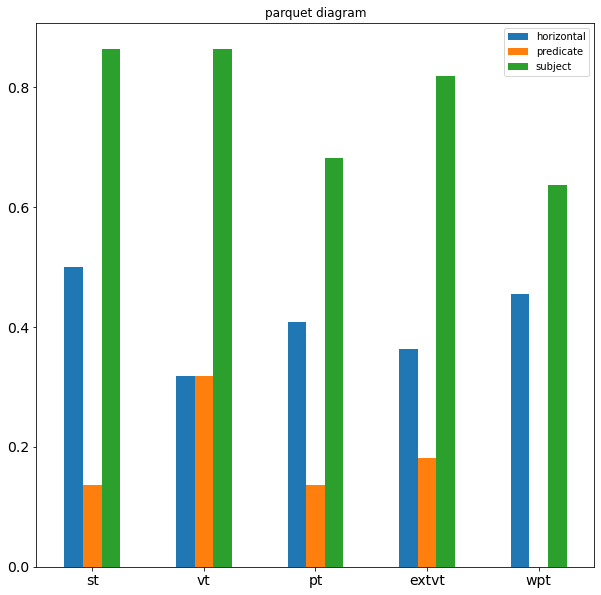

In [26]:
getDiagramSD('parquet')

In [ ]:
# rank_part('csv', 'st')
# a = ['csv']
# b = ['st', 'pt']
# # d = ['storage', 'schema', 'partition']
# d = 3
# for idx,item in enumerate(d):
#     print(idx)
def nested_loop(d, a, b):
    if d > 1:
        for x, y in itertools.zip_longest(a, b):
            print(x, y)
        d -= 1
        nested_loop(d,a,b)
# d = {}
# for x in a:
#     for y in b:
#         print(x,y)
#         # d["{0}".format( )] = "halo"
#         rank_dataframe_rscore.loc[rank_dataframe_rscore.index.str.contains(fr'(?=.*\b{x}\b)(?=.*\b{y}\b)', regex=True)]

In [ ]:
a = ['csv']
b = ['st', 'pt']
# d = ['storage', 'schema', 'partition']
d = 3
nested_loop(d,a,b)

In [ ]:
import itertools

a = ['csv', 'avro']
b = ['st', 'pt']
for x, y in itertools.zip_longest(b, a):
    print(x, y)

This is an optimization technique, aim to find the optimal non-dominated solutions or the configuration combinations by optimizing all dimensions at the same time which utilize the NSGA2 Algorithm. <br>
The <b>pareto_Q</b> apply the NSGA2 considering the rank sets obtained by sorting each query result individually. <br>
While the <b>pareto_Agg</b> operates on the single dimensional ranking criteria (schema, partition, storage) which aims to maximizing the performance of the three ranks all together

In [64]:
# PARETO #
# getPareto_Q(250)
getPareto_Agg(100)

# Pareto's Diagram
# getDiagramPareto()

,Solution,Dominated
0,csv_pt_subject,orc_wpt_predicate
1,avro_extvt_predicate,csv_st_horizontal
2,csv_vt_predicate,parquet_extvt_predicate
3,orc_st_predicate,parquet_pt_predicate
4,avro_extvt_subject,csv_st_subject
5,avro_vt_subject,orc_pt_predicate
6,orc_wpt_subject,csv_pt_predicate
7,parquet_vt_subject,parquet_st_predicate
8,orc_st_subject,csv_st_predicate
9,,csv_wpt_horizontal


Conformance is a measure of the adherence of the top-ranked configurations according to the actual query positioning of those configurations

In [ ]:
# HEADLINE RANKING CRITERIA GOODNESS METRICS
# CONFORMANCE
dataset = [100,250]
dimension = ['storage', 'partition', 'schema', 'pareto_Q', 'pareto_Agg']
getConformance(dimension, dataset, 5, 13)

Coherence is the measure agreement between two ranking sets that use the same ranking criteria across different experiments

In [95]:
# COHERENCE
dimension = ['storage', 'partition', 'schema', 'pareto_Q', 'pareto_Agg']
getCoherence(dimension, 100, 250)

,storage,partition,schema,pareto_Q,pareto_Agg
score,0.745761,0.672589,0.681495,0.299712,-0.490578
distance,0.418079,0.443503,0.485311,0.409988,0.637363


CALCULATE COHERENCE

In [65]:
getPareto_Agg(100)
var1 = pd.concat(rank_dataframe, axis = 0)
var1 = var1.loc[list(pareto_agg.values())]
var1 = var1['Result']

getPareto_Agg(250)
var2 = pd.concat(rank_dataframe, axis = 0)
var2 = var2.loc[list(pareto_agg.values())]
var2 = var2['Result']

new_df = pd.concat([var1, var2], axis = 1)
column_name = new_df.columns.values
column_name[0] = str(100) #var1
column_name[1] = str(250) #var2

# new_df.columns = column_name
# new_df = new_df.dropna()
# var1 = new_df[str(100)]
# var2 = new_df[str(250)]

In [66]:
new_df

,100,250
csv_pt_subject,0.772727,NaN
avro_extvt_predicate,0.227273,NaN
csv_vt_predicate,0.454545,NaN
orc_st_predicate,0.227273,0.409091
avro_extvt_subject,0.727273,NaN
avro_vt_subject,0.818182,NaN
orc_wpt_subject,0.681818,NaN
parquet_vt_subject,0.863636,0.863636
orc_st_subject,0.954545,0.818182
parquet_vt_predicate,NaN,0.318182
